In [1]:
%autosave 120
from basicimports import *

Autosaving every 120 seconds
Last ran on /home/tboland1/Dropbox/Crozier Group User- Tara Boland/pymatgen from 2019-02-19 13:16:22.456764. 

home is /home/tboland1/Dropbox/TaraB/DFT/


In [2]:
# Use the 2x2x2 novac ceo2 from formEox lattice constant
wd = home + 'ca2vac/'
dir_pure_isif3 = home +'formEox/nfa0-1vceo2/novac/'
temp_struct = (Poscar.from_file(filename=dir_pure_isif3+"POSCAR").structure)
temp_struct.lattice

Lattice
    abc : 11.004306114489612 11.004306114489612 11.004306114489612
 angles : 90.0 90.0 90.0
 volume : 1332.5637315461017
      A : 11.004306114489612 0.0 0.0
      B : 0.0 11.004306114489612 0.0
      C : 0.0 0.0 11.004306114489612

# OrderDisorderedStructureTransformation
High Level Information
* use pickle to save the variables which take a while to compute

General Steps Taken
* create simulation structure cell
* assign partial occupancy 
* Use ODST to enumerate all possible structures
* Use Structure matcher (SM) to get crystallographically unique structures
* Collect structures and data to sum up the information

Conventional CeO2 unit Cell
* 2x2x2 super cell 
* 2 Ca solute atom
* 0 O$_{vac}$

In [3]:
# change just Ca ( enter total # of Ca you want)
Ca = 2
con_Ca = (Ca)/32
con_Ce = 1-con_Ca
con_O = (64-0)/64

specie = [{"Ce4+": con_Ce, "Ca2+": con_Ca}, {"O2-": con_O}]
structure = Structure.from_spacegroup("Fm-3m", Lattice.cubic(5.494), specie,
                                      [[0, 0, 0], [0.25, 0.25, 0.25]])

# obtain a copy of the structure 
struct = structure.copy()
struct.make_supercell([2,2,2])

# load the transformer
from pymatgen.transformations.standard_transformations import \
OrderDisorderedStructureTransformation
odst = OrderDisorderedStructureTransformation()

## PICKLED #odst_2x2x2nOv_structs = odst.apply_transformation(struct, return_ranked_list=1000000)
# load Pickled var to save time
# Original pickling of #with open("def2ca_odst_2x2x2nOv.pkl",'wb') as f:#    pickle.dump(odst_2x2x2nOv_structs,f)
with open("../pkl/def2ca_odst_2x2x2nOv.pkl", 'rb') as f:
    odst_2x2x2nOv_structs = pickle.load(f)

print('There is a total of {} structure(s) created using the ODST.\n'
      'The composition is {}.\n'.format(
          len(odst_2x2x2nOv_structs), odst_2x2x2nOv_structs[0]['structure'].composition))

There is a total of 496 structure(s) created using the ODST.
The composition is Ca2+2 Ce4+30 O2-64.



In [4]:
# remove duplicates
from pymatgen.analysis.structure_matcher import StructureMatcher
matcher = StructureMatcher()

# Pass a list of structures to the matcher so the SM can group the structures by their similarity
## PICKLED #matches_2x2x2nOv = matcher.group_structures([d["structure"] for d in odst_2x2x2nOv_structs])
# Original pickling of #with open("def2Ca_matches2x2x2nOv.pkl",'wb') as f:#    pickle.dump(matches_2x2x2nOv,f)
with open("../pkl/def2Ca_matches2x2x2nOv.pkl", 'rb') as f:
    matches_2x2x2nOv = pickle.load(f)


In [5]:
# collect # of groups, number frequency for each struct & disp data

# the grouping of all structures by structural uniquiness found
caArrange_groups = [matches_2x2x2nOv[i][0] for i in range(len(matches_2x2x2nOv))]

# the total number of unique structures found
unique_count = len(caArrange_groups)

# the frequency with which each unique structure occurres
## PICKLED #num_freq =  [len(matches_2x2x2nOv[i]) for i in range(len(matches_2x2x2nOv))]

# load Pickled var to save time
with open("../pkl/def2Ca_num_freq.pkl", 'rb') as f:
    num_freq = pickle.load(f)
# Original pickling of #with open("def2Ca_num_freq.pkl",'wb') as f:#    pickle.dump(num_freq,f)

print("The total number of unique structures found is {}.\n"
       "The number frequency with which each structure occures is \n\t {}.".format(
           unique_count, ' '.join([str(x) for x in num_freq])))

The total number of unique structures found is 5.
The number frequency with which each structure occures is 
	 16 48 192 48 192.


Modify the lattice so vasp doesn't have to relax the structure as far.

In [6]:
for struct,num in zip(caArrange_groups,num_freq):
    struct.modify_lattice(temp_struct.lattice)

## Generate the O$_{vac}$'s

### PartialRemoveSitesTransformation
Comments
* must have oxidation state (added for ODST)
* Initialize the CrystalNN package
* Pass the Ca sites to cNN to dope.
* Isolate the solute atom and use the CNN tool to get a list of sites to pass to the transformation

Pickling performed here

For each solute atom: find the 1NN's 
* use cNN to find the NN for each atom
* create a data structure of the 1NN information form which we can remove an O atom to create O$_{vac}$'s
    * each entry corresponds to the NN information for the respective site in the structure
    * the sites index can be referenced using the defect_sites variable. The index is one-to-one 

In [7]:
# variable to pass to function
NN = [0, 3]  # 1NN shell
defect_type = 'Ca'  # defect type
# all the ca arrangements - there are currently 5
structs = caArrange_groups
rm_under_over_coord = [6, 8]

# the function
'''
Need to find the charge neutrality portion of this code on line 58
'''
from pymatgen.transformations.site_transformations import \
PartialRemoveSitesTransformation
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen.analysis.local_env import CrystalNN

cNN = CrystalNN(cation_anion=True, distance_cutoffs=(NN))
matcher = StructureMatcher()
'''
# {config_structs_#: [all possible defect sub-structure locations]}
config_Struct_Substruct_dict = {}

counter = 0
for tmp_struct in structs:
    defect_sites = [
        tmp_struct[defect_site] for defect_site in [
            tmp_struct.index(site) for site in tmp_struct
            if str(site.specie.element) == defect_type
        ]
    ]

    nn_data = [
        cNN.get_nn_data(structure=tmp_struct, n=tmp_struct.index(defect_site))
        for defect_site in defect_sites
    ]
    nn_site_index = [
        each_site['site_index'] for each_defect in nn_data
        for each_site in each_defect[0]
    ]
    prst = PartialRemoveSitesTransformation(
        [nn_site_index], [len(nn_data) / len(nn_site_index)])
    prst_structs = [
        each_element['structure']
        for each_element in prst.apply_transformation(
            structure=tmp_struct, return_ranked_list=10000)
    ]

    matches = matcher.group_structures(prst_structs)
    sub_structs = [matches[i][0] for i in range(len(matches))]
    unique_count = len(sub_structs)
    print((
        "The total number unique sub-structures found is {}.\n"
        .format(unique_count)))

    rm_list = []
    for struct in sub_structs:
        concen_dict = struct.composition.get_el_amt_dict()
        if concen_dict['O'] != (
                concen_dict['Ce'] + concen_dict['Ca']) * 2 - concen_dict['Ca']:
            sub_structs.remove(struct)
            continue
        defect_sites = [
            struct[defect_site] for defect_site in [
                struct.index(site) for site in struct
                if str(site.specie.element) == defect_type
            ]
        ]
        nn_data = [
            cNN.get_nn_data(structure=struct, n=struct.index(defect_site))
            for defect_site in defect_sites
        ]
        site_coord = [len(nn_data[i][0]) for i in range(len(nn_data))]
        if set(site_coord).issubset(rm_under_over_coord) == True:
            print('removing structure for invalid under/over coord')
            rm_list.append(sub_structs.index(struct))

    rm_list.reverse()
    for index in rm_list:
        sub_structs.pop(index)
    config_Struct_Substruct_dict['config_structs_' + str(counter)] = sub_structs
    counter += 1
# Original pickling of 
with open("../pkl/def_config_Struct_Substruct_dict.pkl",'wb') as f:
    pickle.dump(config_Struct_Substruct_dict,f)'''
# load Pickled var to save time
with open("../pkl/def_config_Struct_Substruct_dict.pkl", 'rb') as f:
    config_Struct_Substruct_dict = pickle.load(f)

In [8]:
# print keys,# of vacancy containing structures per unique Ca arrangement, S.M. results 
for key in config_Struct_Substruct_dict.keys():
    # collect the data for how many configuration for each Ca arrangement
    print(key, len(config_Struct_Substruct_dict[key]))
    struct = config_Struct_Substruct_dict[key]
    matches = matcher.group_structures(struct)
    # grouping of all structures by structural uniquiness found
    groups = [matches[i][0] for i in range(len(matches))]
    # the total number of unique structures found
    unique_count = len(groups)
    print(unique_count)

config_structs_0 4
4
config_structs_1 6
6
config_structs_2 14
14
config_structs_3 6
6
config_structs_4 13
13


In [9]:
# get Ca Ca spacing
for key in config_Struct_Substruct_dict:
    print(key)
    config_Struct_Substruct_dict[key][0].remove_oxidation_states()
    struct = config_Struct_Substruct_dict[key][0]
    sites_itt = [struct.index(site) 
                 for site in struct.sites 
                 if site.species_string == 'Ca']
    print('The Ca-Ca distance is {}'.format(
        struct.distance_matrix[sites_itt[0]][sites_itt[1]]))
    gvl(config_Struct_Substruct_dict[key][0])

config_structs_0
The Ca-Ca distance is 9.530008646168433


config_structs_1
The Ca-Ca distance is 7.781219475808193


config_structs_2
The Ca-Ca distance is 6.738733738472128


config_structs_3
The Ca-Ca distance is 5.502153057244806


config_structs_4
The Ca-Ca distance is 3.8906097379040974


## Create DFT files
This is the initial relaxation for the 2 Ca atom structures.

In [10]:
# high KP initial rlx (done)
for key in config_Struct_Substruct_dict.keys():
    from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
    path = wd+'ca_cf_'+key.split('_')[2]+'/'
    #os.makedirs(wd+'ca_cf_'+key.split('_')[2])
    # create the structure
    struct = config_Struct_Substruct_dict[key][0]
    struct.remove_oxidation_states()
    struct.to(filename = path +'POSCAR_'+key.split('_')[2], fmt = 'POSCAR')
    # create INCAR
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    relax_init_incar['System'] = "Ca 2 vac initial relax"+key
    relax_init_incar['NPAR']   = 2
    relax_init_incar['KPAR']   = 1
    relax_init_incar['ENCUT']  = 520
    relax_init_incar['ISIF']   = 3
    relax_init_incar['ISPIN']  = 2
    
    relax_init_incar.write_file(path+'INCAR')
    # create KPOINTS
    kp_file = Kpoints.automatic_density(structure=struct,kppa=800)
    kp_file.write_file(path+'KPOINTS')


# slurm for each calc
for key in config_Struct_Substruct_dict.keys():
    path = wd+'ca_cf_'+key.split('_')[2]+'/'
    with open(path + "parallel.sh", "w") as f:
        f.write(
            "#!/bin/bash\n"
            "#SBATCH -J Ca2cf" + key.split('_')[2] + '\n'
            "#SBATCH -t 1-00:00\n"
            "#SBATCH -n 56\n"
            "#SBATCH -q aggressive \n"
            "#SBATCH --mem-per-cpu=4000\n"
            "#SBATCH --exclusive\n"
            "#SBATCH -o error.%j.out\n"
            "#SBATCH --mail-user=tboland1@asu.edu\n"
            "#SBATCH --mail-type=end\n"
            '\n'
            "module purge\n"
            "cd /scratch/tboland1/ca2vac/"+'ca_cf_'+key.split('_')[2] + '\n'
            '\n'
            "module load intel/2018x\n"
            "module load vasp/5.4.4-elpa\n"
            'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"'
            + '\n'
            "export I_MPI_HYDRA_BOOTSTRAP=slurm " + '\n'
            "export I_MPI_HYDRA_BOOTSTRAP_EXEC=srun" + '\n'
            '\n'
            '\n'
            "mpiexec.hydra vasp_std")

In [11]:
# spin + low ediffg (done)
for key in config_Struct_Substruct_dict.keys():
    from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
    path = wd+'ca_cf_'+key.split('_')[2]+'/'
    struct = config_Struct_Substruct_dict[key][0]
    relax_init_incar['System'] = "Ca 2 vac initial relax"+key
    relax_init_incar['NPAR']   = 2
    relax_init_incar['KPAR']   = 1
    relax_init_incar['ENCUT']  = 520
    relax_init_incar['ISIF']   = 3
    relax_init_incar['ISPIN']  = 2
    relax_init_incar['EDIFFG'] = -0.01
    ## edit to have 2 sig figs after totE power. set ediff to -(totEpow +2)
    relax_init_incar['EDIFF']  = 0.1E-05
    relax_init_incar.write_file(path+'INCAR')

In [12]:
# spE (done)
for key in config_Struct_Substruct_dict.keys():
    from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
    path = wd+'ca_cf_'+key.split('_')[2]+'/'
    struct = config_Struct_Substruct_dict[key][0]
    # create spE INCAR
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    ## edit
    relax_init_incar['System']= "Ca 2 vac spin final E"
    relax_init_incar['NPAR']=2
    relax_init_incar['KPAR']=1
    relax_init_incar['ENCUT']=400
    relax_init_incar['ISIF']=2
    relax_init_incar['NSW']=0
    relax_init_incar['IBRION']=-1
    relax_init_incar['ISPIN']=2
    ## edit to have 2 sig figs after totE power. set ediff to -(totEpow +2)
    relax_init_incar['EDIFF']=0.1E-05
    relax_init_incar.write_file(path+'INCAR')

### Pointless Migration energy Calculations for Peter

config_structs_0: 4 total configs
* far apart 9.53 \AA
    * migrate site 72 in the +y direction
    * migrate site 61 in the +z direction
    
config_structs_4: 13 total configs
* close together 3.89 \AA
    * migrate site 41 in the -x direction
    * migrate site 84 in the -z direction
    

Create the structures at the first transition state per cell

In [13]:
# selective dft structures (done)
keys = ['config_structs_0','config_structs_4']
ref_lattices = ['ca_cf_0','ca_cf_4']

mig_sites = [[72,61],[41,84]]
shift = 0
ox_ox_cf4 = config_Struct_Substruct_dict[keys[1]][0].distance_matrix[41][37]
ox_ox_cf0 = config_Struct_Substruct_dict[keys[0]][0].distance_matrix[41][78]
vec_sites = [  [ [0,ox_ox_cf0/2,0],[0,0,ox_ox_cf0/2] ] ,[ [-ox_ox_cf4/2,0,0],[0,0,-ox_ox_cf4/2] ]  ]
for key,mig_site,vec_site,ref in zip(keys,mig_sites,vec_sites,ref_lattices):
    path = wd+"ppcalcs_mig/norlx/"+key+'/'
    ref_lattice = Poscar.from_file(wd+ref+'/POSCAR').structure.lattice
    #os.makedirs(path)
    for mig,vec in zip(mig_site,vec_site): 
        path = wd+"ppcalcs_mig/norlx/"+key+'/' + str(mig) +'/'
        #os.makedirs(path)
        temp = config_Struct_Substruct_dict[key][0]
        struct = temp.copy()
        struct.translate_sites(
        indices=mig,
        vector=vec,
        frac_coords=False,
        to_unit_cell=True)
        
        
        # find the NN for the migrating site
        NN_site_idx = []
        NN_site_idx.append(mig) # include the vacancy as a site
        struct.remove_oxidation_states()       
        tags = []
        for site in struct:
            if struct.index(site) in NN_site_idx \
            and site.specie.symbol == "Ce":
                tags.append(['T'] * 3)
            elif struct.index(site) in NN_site_idx \
            and site.specie.symbol == "O":
                tag_temp = []
                for el in vec:
                    if el == 0:
                        tag_temp.append('T')
                    else :
                        tag_temp.append('F')
                tags.append(tag_temp)
            else :
                tags.append(['F'] * 3)
        print(mig,tag_temp,vec)        
        trans = ['pos','mid','neg']
        shifts = [0.5,0,-0.5]
        
        from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
        for tran,shift in zip(trans,shifts):
            path = wd+"ppcalcs_mig/norlx/"+key+'/' + str(mig) +'/' + tran + '/'
            #os.mkdir(path)
            # create shifted structure
            temp = struct.copy()
            
            vec_shift = [0,0,0]
            counter = 0
            for el in vec:
                if el != 0:
                    vec_shift[counter] = shift
                else :
                    vec_shift[counter] = 0
                counter += 1
            
            temp.translate_sites(
                indices=mig,
                vector=vec_shift,
                frac_coords=False,
                to_unit_cell=True)
            temp.modify_lattice(ref_lattice)
            temp.to(
                filename=path + "POSCAR_init",
                fmt="POSCAR",selective_dynamics=tags)
            #show_struct_ase(temp)
           
            # create incar
            relax_init_incar = Incar.from_file(wd+'../INCAR')
            relax_init_incar['System'] = "2 Ca & Vac 1NN initial relax"
            relax_init_incar['NPAR']   = 2
            relax_init_incar['KPAR']   = 1
            relax_init_incar['ENCUT']  = 400
            relax_init_incar['ISIF']   = 2
            relax_init_incar['EDIFFG'] = -0.01
            relax_init_incar['EDIFF']  = 0.1E-05
        
            ul = [-1]*len(struct.symbol_set)
            uu = [0]*len(struct.symbol_set)
            counter = 0
            for element in list(struct.symbol_set):
                if element == 'Ce':
                    ul[counter] = 3    
                    uu[counter] = 5 
                counter += 1
            relax_init_incar['LDAUL']  = ul
            relax_init_incar['LDAUU']  = uu
            relax_init_incar['LDAUJ']  = [0]*len(struct.symbol_set)
            relax_init_incar.write_file(path+'relax-v0/INCAR')

            # create KPOINTS
            kp_file = Kpoints.automatic_density(
                structure=struct,kppa=50)
            kp_file.write_file(path+'relax-v0/KPOINTS')

            # create POTCAR
            #potcar = Potcar(symbols=list(struct.symbol_set),
            #            functional="PBE")
            #potcar.write_file(path+'relax-v0/POTCAR')

            # slurm for each calc
            with open(path + "relax-v0/parallel.sh", "w") as f:
                f.write(
                    "#!/bin/bash\n"

                    "#SBATCH -J Ca2vCF"+str(mig)+tran+" \n"

                    "#SBATCH -t 0-06:00\n"
                    "#SBATCH -n 56\n"

                    "#SBATCH -q aggressive \n#SBATCH --mem-per-cpu=4000\n"
                    "#SBATCH --exclusive\n#SBATCH -o error.%j.out\n"

                    "cd /scratch/tboland1/ca2vac/ppcalcs_mig/norlx/"+key+'/'+str(mig)+'/'+tran+'/' +"\n"

                    "\nmodule load intel/2018x\nmodule load vasp/5.4.4-elpa\n"
                    'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"\n'
                    "export I_MPI_HYDRA_BOOTSTRAP=slurm\nexport I_MPI_HYDRA_BOOTSTRAP_EXEC=srun\n\n\n"
                    "mpiexec.hydra vasp_gam")

72 ['T', 'F', 'T'] [0, 1.375538264311201, 0]
61 ['T', 'T', 'F'] [0, 0, 1.375538264311201]
41 ['F', 'T', 'T'] [-1.375538264311201, 0, 0]
84 ['T', 'T', 'F'] [0, 0, -1.375538264311201]


In [15]:
# hi kp rlx (done)
keys = ['config_structs_0','config_structs_4']
ref_lattices = ['ca_cf_0','ca_cf_4']

mig_sites = [[72,61],[41,84]]
shift = 0
ox_ox_cf4 = config_Struct_Substruct_dict[keys[1]][0].distance_matrix[41][37]
ox_ox_cf0 = config_Struct_Substruct_dict[keys[0]][0].distance_matrix[41][78]
vec_sites = [  [ [0,ox_ox_cf0/2,0],[0,0,ox_ox_cf0/2] ] ,[ [-ox_ox_cf4/2,0,0],[0,0,-ox_ox_cf4/2] ]  ]

for key,mig_site,vec_site,ref in zip(keys,mig_sites,vec_sites,ref_lattices):
    path = wd+"ppcalcs_mig/norlx/"+key+'/'
    #os.makedirs(path)
    for mig,vec in zip(mig_site,vec_site): 
        path = wd+"ppcalcs_mig/norlx/"+key+'/' + str(mig) +'/'
                
        trans = ['pos','mid','neg']
        shifts = [0.5,0,-0.5]
        
        from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
        for tran,shift in zip(trans,shifts):
            path = wd+"ppcalcs_mig/norlx/"+key+'/' + str(mig) +'/' + tran + '/'


            # create incar
            relax_init_incar = Incar.from_file(wd+'../INCAR')
            relax_init_incar['System'] = "2 Ca & Vac 1NN High KP relax"
            relax_init_incar['NPAR']   = 2
            relax_init_incar['KPAR']   = 2
            relax_init_incar['ENCUT']  = 400
            relax_init_incar['ISIF']   = 2
            relax_init_incar['ISPIN']  = 2
            relax_init_incar['EDIFFG'] = -0.01
            relax_init_incar['EDIFF']  = 0.1E-05
        
            ul = [-1]*len(struct.symbol_set)
            uu = [0]*len(struct.symbol_set)
            counter = 0
            for element in list(struct.symbol_set):
                if element == 'Ce':
                    ul[counter] = 3    
                    uu[counter] = 5 
                counter += 1
            relax_init_incar['LDAUL']  = ul
            relax_init_incar['LDAUU']  = uu
            relax_init_incar['LDAUJ']  = [0]*len(struct.symbol_set)
            #relax_init_incar.write_file(path+'INCAR')

            # create KPOINTS
            kp_file = Kpoints.automatic_density(
                structure=struct,kppa=800)
            #kp_file.write_file(path+'KPOINTS')


In [16]:
# spE (done)
keys = ['config_structs_0','config_structs_4']
ref_lattices = ['ca_cf_0','ca_cf_4']

mig_sites = [[72,61],[41,84]]
shift = 0
ox_ox_cf4 = config_Struct_Substruct_dict[keys[1]][0].distance_matrix[41][37]
ox_ox_cf0 = config_Struct_Substruct_dict[keys[0]][0].distance_matrix[41][78]
vec_sites = [  [ [0,ox_ox_cf0/2,0],[0,0,ox_ox_cf0/2] ] ,[ [-ox_ox_cf4/2,0,0],[0,0,-ox_ox_cf4/2] ]  ]

for key,mig_site,vec_site,ref in zip(keys,mig_sites,vec_sites,ref_lattices):
    path = wd+"ppcalcs_mig/norlx/"+key+'/'
    #os.makedirs(path)
    for mig,vec in zip(mig_site,vec_site): 
        path = wd+"ppcalcs_mig/norlx/"+key+'/' + str(mig) +'/'
                
        trans = ['pos','mid','neg']
        shifts = [0.5,0,-0.5]
        
        from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
        for tran,shift in zip(trans,shifts):
            path = wd+"ppcalcs_mig/norlx/"+key+'/' + str(mig) +'/' + tran + '/'


            # create incar
            relax_init_incar = Incar.from_file(wd+'../INCAR')
            relax_init_incar['System'] = "2 Ca & Vac 1NN spe"
            relax_init_incar['NPAR']   = 2
            relax_init_incar['KPAR']   = 1
            relax_init_incar['ENCUT']  = 400
            relax_init_incar['ISIF']   = 2
            relax_init_incar['ISPIN']  = 2
            relax_init_incar['EDIFF']  = 0.1E-05
            relax_init_incar['NSW']     = 0
            relax_init_incar['IBRION']  = -1
            
            relax_init_incar.pop('EDIFFG')
            relax_init_incar.pop('POTIM')
            
            ul = [-1]*len(struct.symbol_set)
            uu = [0]*len(struct.symbol_set)
            counter = 0
            for element in list(struct.symbol_set):
                if element == 'Ce':
                    ul[counter] = 3    
                    uu[counter] = 5 
                counter += 1
            relax_init_incar['LDAUL']  = ul
            relax_init_incar['LDAUU']  = uu
            relax_init_incar['LDAUJ']  = [0]*len(struct.symbol_set)
            relax_init_incar.write_file(path+'INCAR')

            # create KPOINTS
            kp_file = Kpoints.automatic_density(
                structure=struct,kppa=800)
            kp_file.write_file(path+'KPOINTS')


## Analysis Method norlx

In [18]:
energy_form = {'config_structs_0':-755.00,'config_structs_4':-755.15 }

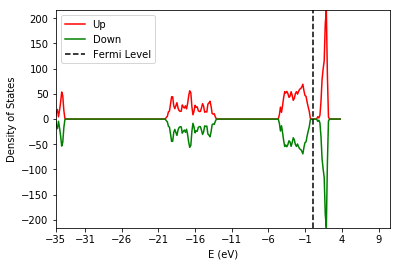

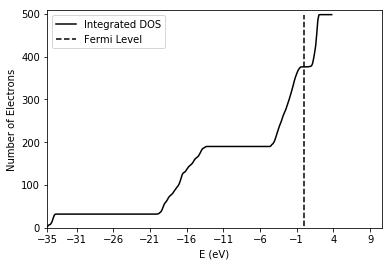

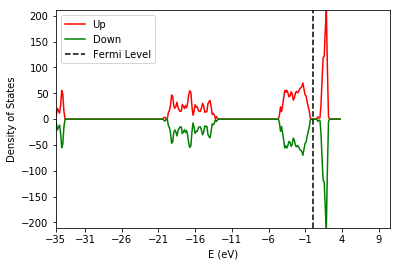

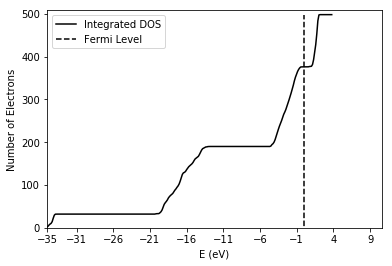

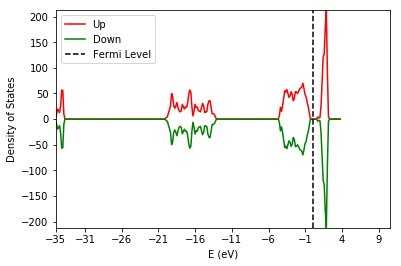

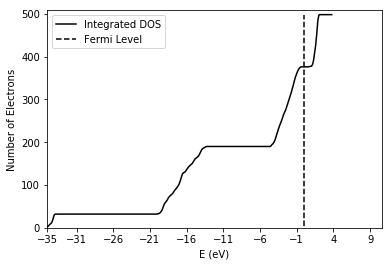

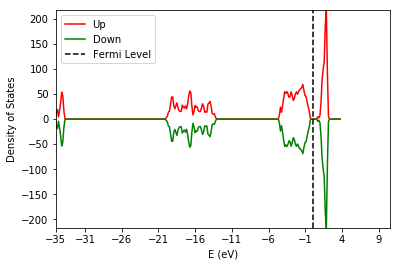

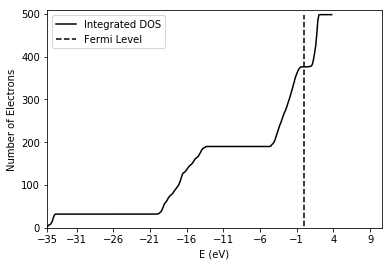

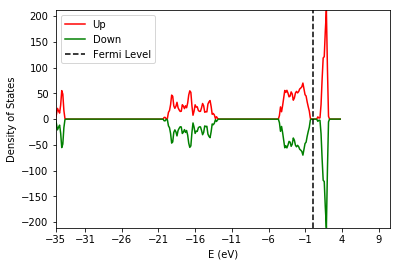

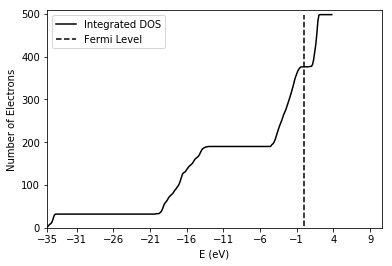

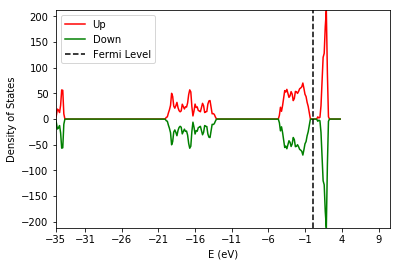

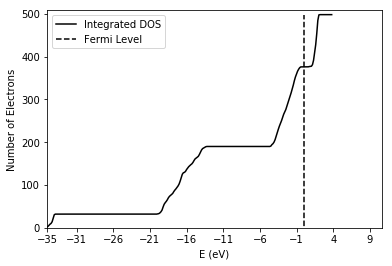

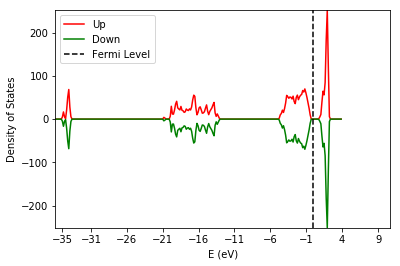

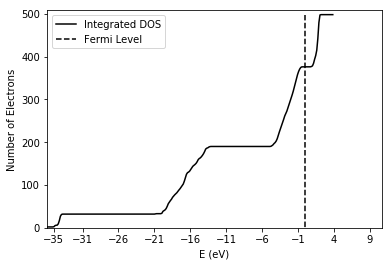

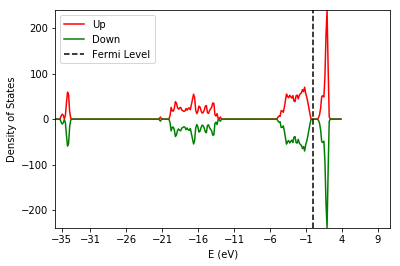

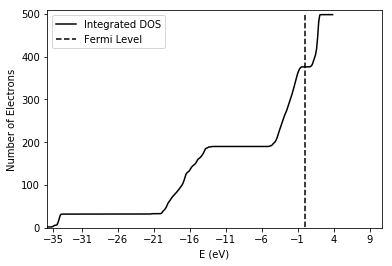

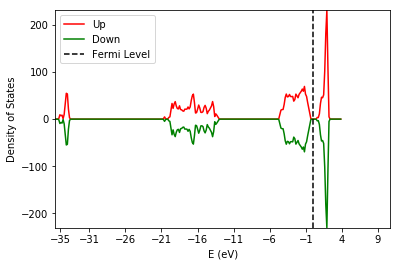

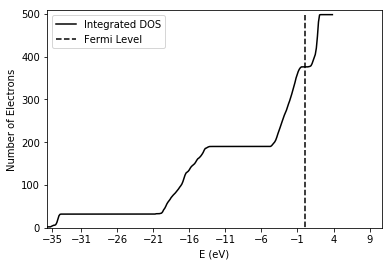

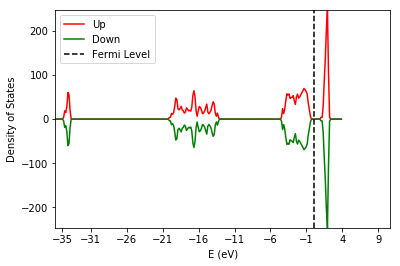

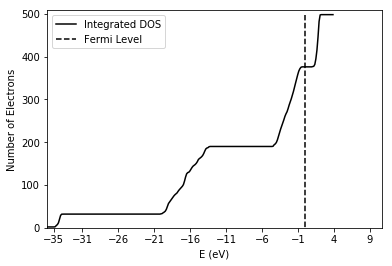

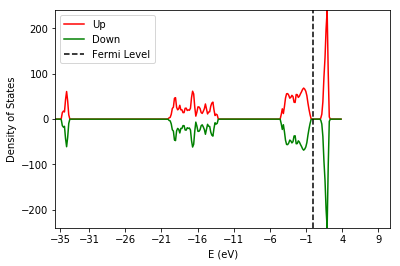

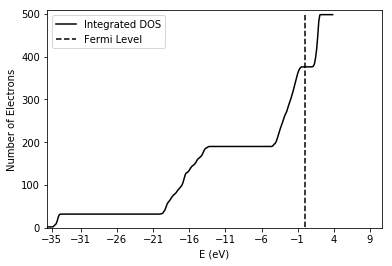

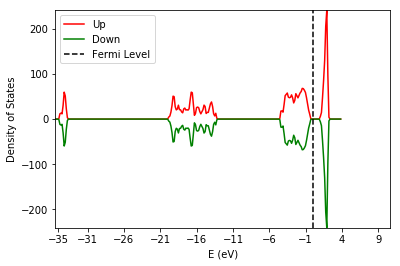

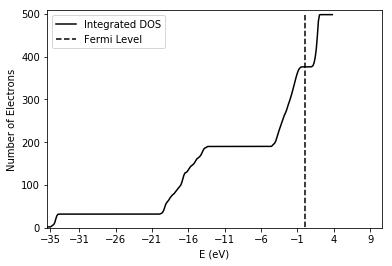

In [19]:
# plot dos 
keys = ['config_structs_0','config_structs_4']
mig_sites = [[72,61],[41,84]]

for key,mig_site in zip(keys,mig_sites):
    for mig in mig_site: 
        trans = ['pos','mid','neg']
        for tran in trans:
            path = wd+"ppcalcs_mig/norlx/"+key+'/' + str(mig) +'/' + tran + '/'
            plot_density_of_states(path+'spE/')

In [20]:
# gather the energy
keys = ['config_structs_0','config_structs_4']
mig_sites = [[72,61],[41,84]]

for key,mig_site in zip(keys,mig_sites):
    for mig in mig_site: 
        trans = ['pos','mid','neg']
        for tran in trans:
            path = wd+"ppcalcs_mig/norlx/"+key+'/' + str(mig) +'/' + tran + '/'
            E_vac = Oszicar(filename=path + "spE/OSZICAR")
            print("The final energy for config {} site {}"
              " at position {} is {:0.2f}".format(key,mig,
                  tran,E_vac.final_energy))

The final energy for config config_structs_0 site 72 at position pos is -750.44
The final energy for config config_structs_0 site 72 at position mid is -750.00
The final energy for config config_structs_0 site 72 at position neg is -750.48
The final energy for config config_structs_0 site 61 at position pos is -750.44
The final energy for config config_structs_0 site 61 at position mid is -750.00
The final energy for config config_structs_0 site 61 at position neg is -750.48
The final energy for config config_structs_4 site 41 at position pos is -751.39
The final energy for config config_structs_4 site 41 at position mid is -750.50
The final energy for config config_structs_4 site 41 at position neg is -750.76
The final energy for config config_structs_4 site 84 at position pos is -751.94
The final energy for config config_structs_4 site 84 at position mid is -751.69
The final energy for config config_structs_4 site 84 at position neg is -751.97


In [21]:
# plot structures
keys = ['config_structs_4','config_structs_0']
mig_sites = [[41,84]],[72,61]]

for key,mig_site in zip(keys,mig_sites):
    for mig in mig_site: 
        trans = ['mid','pos','neg']
        for tran in trans:
            path = wd+"ppcalcs_mig/norlx/"+key+'/' + str(mig) +'/' + tran + '/'
            show_struct_ase(Poscar.from_file(path+'POSCAR_init').structure)

# ISIF 2 Migration Energy

Sync command

    rsync -azPn isif2/ tboland1@agave.asu.edu:/scratch/tboland1/ca2vac/ppcalcs_mig/isif2/
    
    rsync -azPn --include='KPOINTS' --include='INCAR' --include='*/' --exclude='*' isif2/ tboland1@agave.asu.edu:/scratch/tboland1/ca2vac/ppcalcs_mig/isif2/
    
    rsync -azPn --include='INCAR' --include='*/' --exclude='*' isif2/tboland1@agave.asu.edu:/scratch/tboland1/ca2vac/ppcalcs_mig/isif2/
    
    rsync -azPn --exclude='WAVECAR*' --include='*' tboland1@agave.asu.edu:/scratch/tboland1/ca2vac/ppcalcs_mig/isif2/ isif2/

In [19]:
# selective dft structures (done)
keys = ['config_structs_0','config_structs_4']
ref_lattices = ['ca_cf_0','ca_cf_4']

mig_sites = [[72,61],[41,84]]
shift = 0
ox_ox_cf4 = config_Struct_Substruct_dict[keys[1]][0].distance_matrix[41][37]
ox_ox_cf0 = config_Struct_Substruct_dict[keys[0]][0].distance_matrix[41][78]
vec_sites = [  [ [0,ox_ox_cf0/2,0],[0,0,ox_ox_cf0/2] ] ,[ [-ox_ox_cf4/2,0,0],[0,0,-ox_ox_cf4/2] ]  ]

for key,mig_site,vec_site,ref in zip(keys,mig_sites,vec_sites,ref_lattices):
    path = wd+"ppcalcs_mig/isif2/"+key+'/'
    ref_lattice = Poscar.from_file(wd+ref+'/POSCAR').structure.lattice
    #os.makedirs(path)
    for mig,vec in zip(mig_site,vec_site): 
        path = wd+"ppcalcs_mig/isif2/"+key+'/' + str(mig) +'/'
        #os.makedirs(path)
        temp = config_Struct_Substruct_dict[key][0]
        struct = temp.copy()
        struct.translate_sites(
        indices=mig,
        vector=vec,
        frac_coords=False,
        to_unit_cell=True)
        
        
        # find the NN for the migrating site
        NN_site_idx = []
        NN_site_idx.append(mig) # include the vacancy as a site
        struct.remove_oxidation_states()       
        tags = []
        for site in struct:
            if struct.index(site) in NN_site_idx \
            and site.specie.symbol == "Ce":
                tags.append(['T'] * 3)
            elif struct.index(site) in NN_site_idx \
            and site.specie.symbol == "O":
                tag_temp = []
                for el in vec:
                    if el == 0:
                        tag_temp.append('T')
                    else :
                        tag_temp.append('F')
                tags.append(tag_temp)
            else :
                tags.append(['T'] * 3)
        print(mig,tag_temp,vec)        
        trans = ['pos','mid','neg']
        shifts = [0.5,0,-0.5]
        
        from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
        for tran,shift in zip(trans,shifts):
            path = wd+"ppcalcs_mig/isif2/"+key+'/' + str(mig) +'/' + tran + '/'
            #os.mkdir(path)
            # create shifted structure
            temp = struct.copy()
            
            vec_shift = [0,0,0]
            counter = 0
            for el in vec:
                if el != 0:
                    vec_shift[counter] = shift
                else :
                    vec_shift[counter] = 0
                counter += 1
            
            temp.translate_sites(
                indices=mig,
                vector=vec_shift,
                frac_coords=False,
                to_unit_cell=True)
            temp.modify_lattice(ref_lattice)
            temp.to(
                filename=path + "POSCAR_init",
                fmt="POSCAR",selective_dynamics=tags)
            show_struct_ase(temp)
           
            # create incar
            relax_init_incar = Incar.from_file(wd+'../INCAR')
            relax_init_incar['System'] = "2 Ca & Vac 1NN initial relax"
            relax_init_incar['NPAR']   = 2
            relax_init_incar['KPAR']   = 1
            relax_init_incar['ENCUT']  = 400
            relax_init_incar['ISIF']   = 2
            relax_init_incar['EDIFFG'] = -0.01
            relax_init_incar['EDIFF']  = 0.1E-05
        
            ul = [-1]*len(struct.symbol_set)
            uu = [0]*len(struct.symbol_set)
            counter = 0
            for element in list(struct.symbol_set):
                if element == 'Ce':
                    ul[counter] = 3    
                    uu[counter] = 5 
                counter += 1
            relax_init_incar['LDAUL']  = ul
            relax_init_incar['LDAUU']  = uu
            relax_init_incar['LDAUJ']  = [0]*len(struct.symbol_set)
            relax_init_incar.write_file(path+'INCAR')

            # create KPOINTS
            kp_file = Kpoints.automatic_density(
                structure=struct,kppa=50)
            kp_file.write_file(path+'KPOINTS')

            # create POTCAR
            potcar = Potcar(symbols=list(struct.symbol_set),
                        functional="PBE")
            potcar.write_file(path+'POTCAR')

            # slurm for each calc
            with open(path + "parallel.sh", "w") as f:
                f.write(
                    "#!/bin/bash\n"

                    "#SBATCH -J Ca2vCF"+str(mig)+tran+" \n"

                    "#SBATCH -t 0-06:00\n"
                    "#SBATCH -n 56\n"

                    "#SBATCH -q aggressive \n#SBATCH --mem-per-cpu=4000\n"
                    "#SBATCH --exclusive\n#SBATCH -o error.%j.out\n"

                    "cd /scratch/tboland1/ca2vac/ppcalcs_mig/isif2/"+key+'/'+str(mig)+'/'+tran+'/' +"\n"

                    "\nmodule load intel/2018x\nmodule load vasp/5.4.4-elpa\n"
                    'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"\n'
                    "export I_MPI_HYDRA_BOOTSTRAP=slurm\nexport I_MPI_HYDRA_BOOTSTRAP_EXEC=srun\n\n\n"
                    "mpiexec.hydra vasp_gam")

72 ['T', 'F', 'T'] [0, 1.375538264311201, 0]
61 ['T', 'T', 'F'] [0, 0, 1.375538264311201]
41 ['F', 'T', 'T'] [-1.375538264311201, 0, 0]
84 ['T', 'T', 'F'] [0, 0, -1.375538264311201]


In [20]:
# hi kp rlx (running)
keys = ['config_structs_0','config_structs_4']
ref_lattices = ['ca_cf_0','ca_cf_4']

mig_sites = [[72,61],[41,84]]
shift = 0
ox_ox_cf4 = config_Struct_Substruct_dict[keys[1]][0].distance_matrix[41][37]
ox_ox_cf0 = config_Struct_Substruct_dict[keys[0]][0].distance_matrix[41][78]
vec_sites = [  [ [0,ox_ox_cf0/2,0],[0,0,ox_ox_cf0/2] ] ,[ [-ox_ox_cf4/2,0,0],[0,0,-ox_ox_cf4/2] ]  ]

for key,mig_site,vec_site,ref in zip(keys,mig_sites,vec_sites,ref_lattices):
    path = wd+"ppcalcs_mig/isif2/"+key+'/'
    for mig,vec in zip(mig_site,vec_site): 
        path = wd+"ppcalcs_mig/isif2/"+key+'/' + str(mig) +'/'
                
        trans = ['pos','mid','neg']
        shifts = [0.5,0,-0.5]
        
        from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
        for tran,shift in zip(trans,shifts):
            path = wd+"ppcalcs_mig/isif2/"+key+'/' + str(mig) +'/' + tran + '/'


            # create incar
            relax_init_incar = Incar.from_file(wd+'../INCAR')
            relax_init_incar['System'] = "2 Ca & Vac isif2 High KP relax"
            relax_init_incar['NPAR']   = 2
            relax_init_incar['KPAR']   = 2
            relax_init_incar['ENCUT']  = 400
            relax_init_incar['ISIF']   = 2
            relax_init_incar['ISPIN']  = 2
            relax_init_incar['EDIFFG'] = -0.01
            relax_init_incar['EDIFF']  = 0.1E-05
        
            ul = [-1]*len(struct.symbol_set)
            uu = [0]*len(struct.symbol_set)
            counter = 0
            for element in list(struct.symbol_set):
                if element == 'Ce':
                    ul[counter] = 3    
                    uu[counter] = 5 
                counter += 1
            relax_init_incar['LDAUL']  = ul
            relax_init_incar['LDAUU']  = uu
            relax_init_incar['LDAUJ']  = [0]*len(struct.symbol_set)
            relax_init_incar.write_file(path+'INCAR')

            # create KPOINTS
            kp_file = Kpoints.automatic_density(
                structure=struct,kppa=800)
            kp_file.write_file(path+'KPOINTS')


In [ ]:
# spE ( port) 
keys = ['config_structs_0','config_structs_4']
ref_lattices = ['ca_cf_0','ca_cf_4']

mig_sites = [[72,61],[41,84]]
shift = 0
ox_ox_cf4 = config_Struct_Substruct_dict[keys[1]][0].distance_matrix[41][37]
ox_ox_cf0 = config_Struct_Substruct_dict[keys[0]][0].distance_matrix[41][78]
vec_sites = [  [ [0,ox_ox_cf0/2,0],[0,0,ox_ox_cf0/2] ] ,[ [-ox_ox_cf4/2,0,0],[0,0,-ox_ox_cf4/2] ]  ]

for key,mig_site,vec_site,ref in zip(keys,mig_sites,vec_sites,ref_lattices):
    path = wd+"ppcalcs_mig/norlx/"+key+'/'
    #os.makedirs(path)
    for mig,vec in zip(mig_site,vec_site): 
        path = wd+"ppcalcs_mig/norlx/"+key+'/' + str(mig) +'/'
                
        trans = ['pos','mid','neg']
        shifts = [0.5,0,-0.5]
        
        from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
        for tran,shift in zip(trans,shifts):
            path = wd+"ppcalcs_mig/norlx/"+key+'/' + str(mig) +'/' + tran + '/'


            # create incar
            relax_init_incar = Incar.from_file(wd+'../INCAR')
            relax_init_incar['System'] = "2 Ca & Vac 1NN spe"
            relax_init_incar['NPAR']   = 2
            relax_init_incar['KPAR']   = 1
            relax_init_incar['ENCUT']  = 400
            relax_init_incar['ISIF']   = 2
            relax_init_incar['ISPIN']  = 2
            relax_init_incar['EDIFF']  = 0.1E-05
            relax_init_incar['NSW']     = 0
            relax_init_incar['IBRION']  = -1
            
            relax_init_incar.pop('EDIFFG')
            relax_init_incar.pop('POTIM')
            
            ul = [-1]*len(struct.symbol_set)
            uu = [0]*len(struct.symbol_set)
            counter = 0
            for element in list(struct.symbol_set):
                if element == 'Ce':
                    ul[counter] = 3    
                    uu[counter] = 5 
                counter += 1
            relax_init_incar['LDAUL']  = ul
            relax_init_incar['LDAUU']  = uu
            relax_init_incar['LDAUJ']  = [0]*len(struct.symbol_set)
            relax_init_incar.write_file(path+'INCAR')

            # create KPOINTS
            kp_file = Kpoints.automatic_density(
                structure=struct,kppa=800)
            kp_file.write_file(path+'KPOINTS')


# Create Pratik's Method Migration Energy

In [ ]:
# write out the POSCAR, INCAR, KPOINTS and POTCAR files
for key in config_Struct_Substruct_dict.keys():
    from pymatgen.io.vasp.inputs import Incar, Kpoints, Potcar
    
    path = wd+'/migration/ispin2/' + 'ca_cf_'+key.split('_')[2]+'/'
    
    os.makedirs(path)
    # create the structure
    struct = config_Struct_Substruct_dict[key][0]
    struct.remove_oxidation_states()
    struct.to(filename = path +'POSCAR_'+key.split('_')[2], fmt = 'POSCAR')
    
    # create INCAR
    relax_init_incar = Incar.from_file(wd+'../INCAR')
    relax_init_incar['System']= "Ca 2 vac trans E"+key
    relax_init_incar['NPAR']=2
    relax_init_incar['KPAR']=1
    relax_init_incar['ENCUT']=400
    relax_init_incar['ISIF']=2
    relax_init_incar['ISPIN']=2
    
    relax_init_incar.pop('EDIFFG')
    relax_init_incar.pop('POTIM')
    relax_init_incar.write_file(path+'INCAR')
    
    # create KPOINTS
    kp_file = Kpoints.automatic_density(structure=struct,kppa=800)
    kp_file.write_file(path+'KPOINTS')
    # create POTCAR
    potcar = Potcar(symbols=list(struct.symbol_set),
                functional="PBE")
    potcar.write_file(path+'POTCAR')
    
    # slurm for each calc
    with open(path + "parallel.sh", "w") as f:
        f.write(
            "#!/bin/bash\n"
            "#SBATCH -J Ca2cf" + key.split('_')[2] + '\n'
            "#SBATCH -t 1-00:00\n"
            "#SBATCH -n 56\n"
            "#SBATCH -q aggressive \n"
            "#SBATCH --mem-per-cpu=4000\n"
            "#SBATCH --exclusive\n"
            "#SBATCH -o error.%j.out\n"
            "#SBATCH --mail-user=tboland1@asu.edu\n"
            "#SBATCH --mail-type=end\n"
            '\n'
            "module purge\n"
            "cd /scratch/tboland1/ca2vac/migration/ispin2/"+'ca_cf_'+key.split('_')[2] + '\n'
            '\n'
            "module load intel/2018x\n"
            "module load vasp/5.4.4-elpa\n"
            'export I_MPI_HYDRA_BOOTSTRAP_EXEC_EXTRA_ARGS="--cpu-bind=verbose,none"'
            + '\n'
            "export I_MPI_HYDRA_BOOTSTRAP=slurm " + '\n'
            "export I_MPI_HYDRA_BOOTSTRAP_EXEC=srun" + '\n'
            '\n'
            '\n'
            "mpiexec.hydra vasp_std")